In [30]:
# Pandas is a nice utilitiy that enables some easy data manipulation, especially from a csv
import pandas as pd
# Numpy lets us work with arrays
import numpy as np
import re
# Sklearn provides various modules with a common API
from sklearn import svm, tree, neighbors, neural_network
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.columns[train_data.isna().any()].tolist()

train_data.set_index(keys=['PassengerId'], drop=True, inplace=True)

test_data.set_index(keys=['PassengerId'], drop=True, inplace=True)

train_nan_map = {'Fare': train_data['Fare'].mean(), 'Embarked': train_data['Embarked'].mode()[0]}
test_nan_map = {'Fare': test_data['Fare'].mean(), 'Embarked': test_data['Embarked'].mode()[0]}

train_data.fillna(value=train_nan_map, inplace=True)
test_data.fillna(value=test_nan_map, inplace=True)

#Southampton Cherbourg Queenstown

columns_map = {'Sex': {'male': 0, 'female': 1}}

train_data.replace(columns_map, inplace=True)
test_data.replace(columns_map, inplace=True)

titles = set()

for index, row in train_data.iterrows():
	m = re.search(", ([^\\.]*)", row['Name'])
	title = m.group(1)
	titles.add(title)

for index, row in test_data.iterrows():
	m = re.search(", ([^\\.]*)", row['Name'])
	title = m.group(1)
	titles.add(title)

titles.add("C")
titles.add("Q")
titles.add("S")
new_cols = dict()
for title in titles:
	new_cols[title] = [0 for x in range(0, train_data.shape[0])]


for index, row in train_data.iterrows():
	new_cols[row['Embarked']][index - 1] = 1
	m = re.search(", ([^\\.]*)", row['Name'])
	title = m.group(1)
	new_cols[title][index - 1] = 1

for column in new_cols.keys():
	train_data[column] = new_cols[column]

new_cols = dict()
for title in titles:
	new_cols[title] = [0 for x in range(0, test_data.shape[0])]

for index, row in test_data.iterrows():
	new_cols[row['Embarked']][index - 1 - train_data.shape[0]] = 1
	m = re.search(", ([^\\.]*)", row['Name'])
	title = m.group(1)
	new_cols[title][index - 1 - train_data.shape[0]] = 1

for column in new_cols.keys():
	test_data[column] = new_cols[column]

both = train_data.append(test_data)

title_age_sum = dict()
title_count = dict()

for title in titles:
	title_age_sum[title] = 0
	title_count[title] = 0

for index, row in both.iterrows():
	m = re.search(", ([^\\.]*)", row['Name'])
	title = m.group(1)
	if np.isnan(row['Age']):
		continue
	title_count[title] += 1
	title_age_sum[title] += row['Age']

for index, row in test_data.iterrows():
	m = re.search(", ([^\\.]*)", row['Name'])
	title = m.group(1)
	if not np.isnan(row['Age']):
		continue
	test_data.at[index, 'Age'] = title_age_sum[title] / title_count[title]


for index, row in train_data.iterrows():
	m = re.search(", ([^\\.]*)", row['Name'])
	title = m.group(1)
	if not np.isnan(row['Age']):
		continue
	train_data.at[index, 'Age'] = title_age_sum[title] / title_count[title]

del both['Name']
del both['Cabin']
del both['Ticket']
del both['Embarked']
del both['Survived']

mn = both.min()
mx = both.max()

del test_data['Name']
del test_data['Cabin']
del test_data['Ticket']
del test_data['Embarked']

y_train = train_data.loc[:, 'Survived']

del train_data['Name']
del train_data['Cabin']
del train_data['Ticket']
del train_data['Embarked']
del train_data['Survived']

test_data=(test_data-mn)/(mn+mx)
train_data=(train_data-mn)/(mn+mx)

X_train = train_data.loc[:]

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=10)
y_truth = y_test.values

C:\Users\avnit\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [31]:
#Multi-Layer Perceptron
mlp_clf = neural_network.MLPClassifier(hidden_layer_sizes = (90,), alpha = 1e-20, max_iter = 200, activation='tanh', solver='lbfgs', learning_rate='constant') 
mlp_clf.fit(X_train.values, y_train.values)
pred_mlp_clf = mlp_clf.predict(X_test.values)
hgb_cfl = ensemble.HistGradientBoostingClassifier(loss='auto', learning_rate=0.05)
hgb_cfl.fit(X_train.values, y_train.values)
pred_hgb_cfl = hgb_cfl.predict(X_test.values)
gb_clf = ensemble.GradientBoostingClassifier(loss='exponential', learning_rate=0.5, n_estimators=100, subsample=1.)
gb_clf.fit(X_train.values, y_train.values)
pred_gb_clf = gb_clf.predict(X_test.values)
v_cfl = ensemble.VotingClassifier(estimators=[('mlp', mlp_clf), ('gb', gb_clf),('hgb', hgb_cfl)], voting='hard')
v_cfl.fit(X_train.values, y_train.values)
pred_v_cfl = v_cfl.predict(X_test.values)

In [32]:
#Random Forest
rf_clf = RandomForestClassifier(n_estimators=1750,max_depth=7,min_samples_split=6,min_samples_leaf=6,random_state=20,n_jobs=-1,) 
rf_clf.fit(X_train.values, y_train.values)
pred_rf_clf = rf_clf.predict(X_test.values)

In [33]:
#svm
svm_clf =  svm.SVC(kernel = "poly", tol = 1e-6, degree = 6, gamma = "scale")#
svm_clf.fit(X_train.values, y_train.values)
pred_svm_clf = svm_clf.predict(X_test.values)

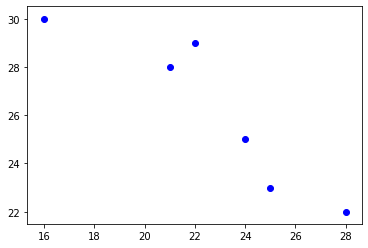

In [36]:
#Create pareto graph
import matplotlib.pyplot as plt
all_pred = [pred_mlp_clf,pred_v_cfl, pred_gb_clf, pred_hgb_cfl, pred_rf_clf, pred_svm_clf]
for element in all_pred:
    tn, fp, fn, tp = confusion_matrix(y_truth, element).ravel()
    plt.scatter(fp,fn, color='b')
plt.xlabel('false positives')
plt.ylabel('false negatives')
plt.show()